In [9]:
dataset <- "ARPAE"
state <- "Emilia-Romagna"
match_dist <- 15000

In [10]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)

source("src/database/tools.R")
source("src/database/insert.R")
source("src/database/write.R")
source("src/database/startup.R")
source("src/database/plot.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/merging/analysis.R")
source("src/merging/display.R")
source("src/merging/combining.R")

conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, state, "state") 

In [11]:
ds_meta <- query_checkpoint_meta(dataset, "qc1", conns$data) |>
    collect()
scia_meta <- query_checkpoint_meta("SCIA", "qc1", conns$data) |>
    collect() |>
    st_md_to_sf() |>
    st_filter(state_boundaries |> st_buffer(dist = 1000), .predicate = st_within) |>
    st_drop_geometry() |>
    filter(!state %in% c("Liguria", "Piemonte", "Lombardia", "Veneto", "Marche", "Toscana"), !(network %in% c("Sinottica", "Mareografica")))
metadata <- bind_rows(ds_meta, scia_meta) |> mutate(key = row_number())
metadata_db <- copy_to(conns$data, metadata, "metas_tmp", overwrite = TRUE)

sensor_matches <- close_matches(metadata_db, match_dist, conns$stations)

data <- query_checkpoint_data(c(dataset, "SCIA"), "qc1", conns$data) |>
    filter(valid) |>
    left_join(metadata_db |> select(dataset, sensor_key, key), by = c("dataset", "sensor_key"))

var_matches <- series_matches(data, sensor_matches, metadata_db)


In [19]:
analysis <- series_matches_analysis(var_matches, data, metadata_db, matches_offsets = 0L)
analysis |> write_xlsx_analysis(file.path("notebooks", "integrazioni_regionali", state, "raw_analysis.xlsx"), starts_with("user_code"))

- onlyagg: 843
- noagg: 843
- orig: 843
- noagg_cet: 842
- hourly: 843
- hourly_noagg: 843

In [17]:
analysis |> filter(f0 > 0.5) |> nrow()

[1] 844

- onlyagg: ~650
- noagg: 718
- orig: 654
- noagg_cet: 601
- hourly: 658
- hourly_noagg: 718

In [18]:
analysis |> filter(f0 > 0.8) |> nrow()

[1] 718

In [ ]:
source(file.path("notebooks", "integrazioni_regionali", state, "procedures", "match_taggers.R"))
source("src/merging/tagging.R")
tagged_analysis <- tag_same_series(analysis) |>
    tag_mergeable() |>
    default_logic(require_all = TRUE)
tagged_analysis |> write_xlsx_analysis(file.path("notebooks", "integrazioni_regionali", state, "tagged_analysis.xlsx"), starts_with("tag_"))


In [38]:
metadata |> st_md_to_sf() |> st_write(file.path("notebooks", "integrazioni_regionali", state, "metadata.kml"))

Writing layer `metadata' to data source 
  `notebooks/integrazioni_regionali/Emilia-Romagna/metadata.kml' using driver `KML'
Writing 670 features with 25 fields and geometry type Point.


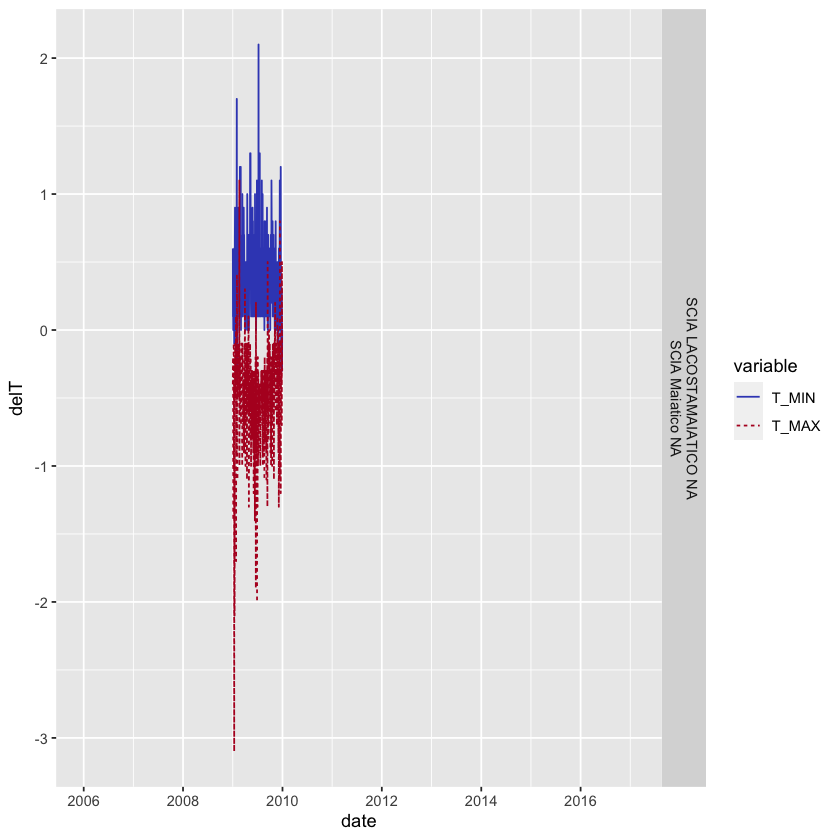

In [35]:
analysis |>
    filter(sensor_key_x == 1427L, sensor_key_y == 1750L, dataset_x == "SCIA", dataset_y == "SCIA") |>
    plot_diffs(data)

In [31]:
g <- tibble(l = c(1, 2, 3, 4), r = c(4, 4, 4, 1)) |> as.matrix() |> igraph::graph_from_edgelist(directed = T)